In [100]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, nsolve
from sympy import cosh, sin , sinh, cos,exp
from scipy.special import factorial
from scipy.special import sph_harm_y    #sph_harm_y(l,m,theta,phi)
from scipy.optimize import fsolve,brentq
from scipy.integrate import quad,quad_vec,simpson
import numba,time
from decimal import Decimal, getcontext
from scipy.interpolate import interp1d
getcontext().prec = 50  #decimal precision

In [101]:
#System
e2=1.43997 ; hbarc=197.3269718 ; amu=931.49432
zp=69 ; Ap=145 ; mass_excess_p=-27.58 ; mp=Ap*amu+mass_excess_p
z1=68 ; A1=144 ; mass_excess_1=-36.61 ; m1=A1*amu+mass_excess_1    #1-> daughter
z2=1  ; A2=1   ; mass_excess_2=7.288971064 ; m2=A2*amu+mass_excess_2
Q=mp-m1-m2
mu=m1*m2/(m1+m2)
P0=0.580
#Potential

#Deformation
beta2 = 0.231  # quadrupole
beta4 = -0.068  # hexadecapole 

#Polarizaton
beta2tilde = 0  
beta4tilde = 0

#spin-orbit
Vso0=6.2 ; rso=1.01*(A1)**(1/3) ; aso=0.75 ; lambda_pi=np.sqrt(2)
L=5; S=0.5; J=5.5

#Vn
a0=0.75 ; r0=1.27*A1**(1/3)-0.1 ; V0=55

#Vc
Rc0 = 1.21 * A1**(1/3)          

#mesh
r = np.linspace(0.03, 30.0, 1000) # avoid too small r


$\frac{\partial}{\partial \theta}Y_{l,m}(\theta,\phi)=\frac{1}{(2l+1)\sin\theta}\left [l(l-m+1)\frac{N_{l,m}}{N_{l+1,m}}Y_{l+1,m}(\theta,\phi)-(l+1)(l+m)\frac{N_{l,m}}{N_{l-1,m}}Y_{l-1,m}(\theta,\phi)]      \right],N_{l,m}=\sqrt{\frac{(2l+1)(l-m)!}{4\pi(l+m)!}}$

$V_{so}=V_{so0}\lambda_\pi^2\frac{1}{r}\frac{d}{dr}\frac{1}{1+\exp[(r-R_{so})/a_{so}]}\vec{\sigma}\cdot\vec{l}=\frac{V_{so0}\lambda_\pi^2}{a_{so}}\times \frac{-e^{\frac{r-R_{so}}{a_{so}}}}{r(1+e^{\frac{r-R_{so}}{a_{so}}})^2}\times\frac{J(J+1)-L(L+1)-S(S+1)}{2}\times2$


Piecewise $K_{\lambda}(r,\theta,\phi)$ with $m=0$ and deformed Coulomb


$V_{cent}=\frac{\hbar^2(l+0.5)^2}{2\mu r^2}$

In [102]:

Nlm=lambda l,m: np.sqrt((2*l+1)/(4*np.pi)*factorial(l-m)/factorial(l+m))
#derivative of Ylm on theta, theta exists on the denominator, so use epsilon to avoid division by zero

def dYlm(l,m,theta,phi):
    if np.sin(theta) <1e-10:
        return 0
    result=(1/(2*l+1)/(np.sin(theta)))*(l*(l-m+1)*Nlm(l,m)/Nlm(l+1,m)*sph_harm_y(l+1,m,theta,phi)-(l+1)*(l+m)*Nlm(l,m)/Nlm(l-1,m)*sph_harm_y(l-1,m,theta,phi))
    return result
#deformed potential,with deformed paras beta, polarization params beta_tilde
#Avoid using zero theta, if needed, set theta=1e-10
def Vn(V0,r0,a0,beta2,beta4,beta2_tilde,beta4_tilde,r,theta):
    Y20=sph_harm_y(2,0,theta,0)  #sph_harm_y(l,m,theta,phi)
    Y40=sph_harm_y(4,0,theta,0)
    r0_theta=r0*(1+beta2*Y20+beta4*Y40)         #deformation

    # delta_theta=1e-6
    # dY20=(sph_harm(0, 2, 0, theta+delta_theta)-sph_harm(0, 2, 0, theta))/(delta_theta)
    # dY40=(sph_harm(0, 4, 0, theta+delta_theta)-sph_harm(0, 4, 0, theta))/(delta_theta)
    dY20=dYlm(2,0,theta,0)
    dY40=dYlm(4,0,theta,0)
    dr0_theta=r0*(beta2*dY20+beta4*dY40)       

# polarization
    a0_theta=a0*np.sqrt(1+(1/r0_theta*dr0_theta)**2)*(1+beta2_tilde*Y20+beta4_tilde*Y40) 

    return -V0/(1+np.exp((r-r0_theta)/a0_theta))

#V_{so}, with lambda_pi being the wave number of pion
def Vso(Vso0,rso,aso,L,S,J,r,theta,beta2,beta4,beta2_tilde,beta4_tilde):
    lambda_pi2=2
    Y20=sph_harm_y(2,0,theta,0)  #sph_harm_y(l,m,theta,phi)
    Y40=sph_harm_y(4,0,theta,0)
    dY20=dYlm(2,0,theta,0)
    dY40=dYlm(4,0,theta,0)
    #deformation
    rso=rso*(1+beta2*Y20+beta4*Y40) 

    #polarization
    drso=rso*(beta2*dY20+beta4*dY40)       
    aso=aso*np.sqrt(1+(1/rso*drso)**2)*(1+beta2_tilde*Y20+beta4_tilde*Y40) 
    return Vso0*lambda_pi2/aso*(-np.exp((r-rso)/aso)/(r*(1+np.exp((r-rso)/aso))**2))*((J*(J+1)-L*(L+1)-S*(S+1))/2)*2

def Vc_vectorized(z1, z2, r, theta, Rc0, beta2, beta4):

    r = np.asarray(r)               

    Y00 = sph_harm_y(0, 0, theta, 0).real
    Y20 = sph_harm_y(2, 0, theta, 0).real
    Y40 = sph_harm_y(4, 0, theta, 0).real

    # mesh theta
    nt = 300  
    t_grid = np.linspace(0, np.pi / 2, nt)
    sin_t = np.sin(t_grid)

    # Rc(t)
    Rc_t = Rc0 * (1 + beta2 * sph_harm_y(2, 0, t_grid, 0).real + beta4 * sph_harm_y(4, 0, t_grid, 0).real)  # (nt,)

    # Klambda(theta,r)  (nt,nr)
    def compute_res(lam):
        Yl0_t = sph_harm_y(lam, 0, t_grid, 0).real  # (nt,)
        K = np.zeros((nt, len(r)))  # (nt, nr)
        
        for i in range(nt):
            Rc = Rc_t[i]
            inside = r <= Rc
            if lam == 2:
                # 原版 log 项
                K[i, inside]  = r[inside]**2 / 5 + r[inside]**2 * np.log(Rc / r[inside])
                K[i, ~inside] = Rc**(lam + 3) / ((lam + 3) * r[~inside]**(lam + 1))
            else:
                K[i, inside]  = (2 * lam + 1) * r[inside]**2 / ((lam + 3) * (lam - 2)) - r[inside]**lam / ((lam - 2) * Rc**(lam - 2))
                K[i, ~inside] = Rc**(lam + 3) / ((lam + 3) * r[~inside]**(lam + 1))
        
        integrand = Yl0_t[:, np.newaxis] * K * sin_t[:, np.newaxis]  # (nt, nr)
        res = 2 * simpson(integrand, x=t_grid, axis=0)  # (nr,)
        return res

    res0 = compute_res(0)
    res2 = compute_res(2)
    res4 = compute_res(4)


    V_0 = 3 * z1 * z2 * e2 / Rc0**3 * 2 * np.pi * Y00 * res0
    V_2 = 3 * z1 * z2 * e2 / Rc0**3 * 2 * np.pi * Y20 / 5 * res2
    V_4 = 3 * z1 * z2 * e2 / Rc0**3 * 2 * np.pi * Y40 / 9 * res4
    
    Vc_tot = V_0 + V_2 + V_4

    return Vc_tot, V_0, V_2, V_4

In [103]:
def compute_gamma_for_theta(theta, Rc0, V0, a0, r0, P0, beta2, beta4, vso, rso, aso, beta2tilde, beta4tilde):

#mesh
    r_values = np.linspace(0.1, 100.0, 300)   # for searching roots
    r_grid   = np.linspace(0.05, 100.0, 1000) # for interpolation

#pre calculate Vn, Vso, Vc
    Vn_grid   = Vn(V0, r0, a0, beta2, beta4, beta2tilde, beta4tilde, r_grid, theta)
    Vso_grid  = Vso(Vso0, rso, aso, L, S, J, r_grid, theta, beta2, beta4, beta2tilde, beta4tilde)
    Vc_grid, _, _, _ = Vc_vectorized(z1, z2, r_grid, theta, Rc0, beta2, beta4)
    
#interpolate Vn, Vso, Vc
    interp_Vn  = interp1d(r_grid, Vn_grid,   kind='cubic', fill_value="extrapolate", bounds_error=False)
    interp_Vso = interp1d(r_grid, Vso_grid,  kind='cubic', fill_value="extrapolate", bounds_error=False)
    interp_Vc  = interp1d(r_grid, Vc_grid,   kind='cubic', fill_value="extrapolate", bounds_error=False)

    def f(r):
        V_cent = hbarc**2 * (L + 0.5)**2 / (2 * mu * r**2)
        return interp_Vn(r) + interp_Vso(r) + interp_Vc(r) + V_cent - Q

    def k(r):
        V_cent = hbarc**2 * (L + 0.5)**2 / (2 * mu * r**2)
        Vtot = interp_Vn(r) + interp_Vso(r) + interp_Vc(r) + V_cent
        arg = (2 * mu / hbarc**2) * np.abs(Vtot - Q)
        return np.sqrt(np.maximum(arg, 0.0))

    def integrand(r):
        return 1 / (2 * k(r))

# Find roots
    f_values = f(r_values)
    roots = []
    for i in range(len(r_values)-1):
        if np.sign(f_values[i]) != np.sign(f_values[i+1]):
            try:
                root = brentq(f, r_values[i], r_values[i+1], xtol=1e-6)
                if root > 0 and not any(np.isclose(root, r, atol=1e-5) for r in roots):
                    roots.append(root)
            except ValueError:
                pass
    roots.sort()

    if len(roots) < 3:
        return np.nan  

# Integrate
    integral_result, _ = quad(integrand, roots[0], roots[1], limit=50)
    F = 1 / integral_result

    action, _ = quad(k, roots[1], roots[2], limit=50)
    Gamma = P0 * F * hbarc**2 / (4 * mu) * np.exp(-2 * action)

# Gamma(theta)
    return Gamma

def Model(V0, a0, r0, P0, Rc0, beta2, beta4, vso, rso, aso, beta2tilde=0, beta4tilde=0, n_theta=30):

    theta_grid = np.linspace(0, np.pi/2, n_theta)
    sin_theta = np.sin(theta_grid)

    gamma_list = []
    for idx, theta in enumerate(theta_grid, 1):

        gamma = compute_gamma_for_theta(
            theta, Rc0, V0, a0, r0, P0, beta2, beta4, vso, rso, aso, beta2tilde, beta4tilde
        )
        gamma_list.append(gamma)

    Gamma_array = np.array(gamma_list)
    integrand = Gamma_array * sin_theta
    Gamma_total = simpson(integrand, x=theta_grid)


# Gamma(theta) and Gamma
    return theta_grid, Gamma_array, Gamma_total

/var/folders/b3/wwgr7yrd62xdrw_44kj1f4gh0000gn/T/ipykernel_9954/4136196216.py:47: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  integral_result, _ = quad(integrand, roots[0], roots[1], limit=50)
/var/folders/b3/wwgr7yrd62xdrw_44kj1f4gh0000gn/T/ipykernel_9954/4136196216.py:47: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral_result, _ = quad(integrand, roots[

Total width: 2.225e-16 MeV
2.0487585698849264e-06


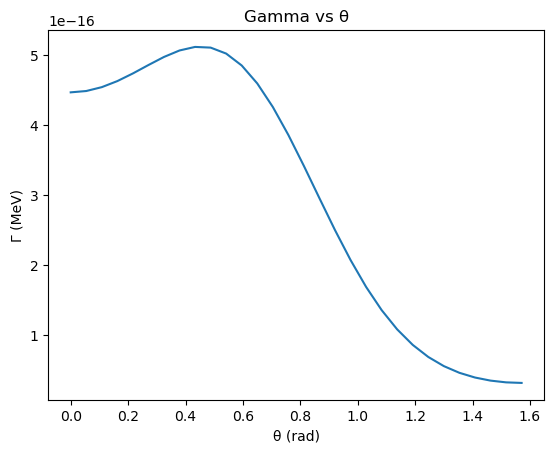

In [104]:
theta_arr, Gamma_arr, Gamma_ave = Model(V0, a0, r0, P0, Rc0, beta2, beta4, Vso0, rso, aso)

print(f"Total width: {Gamma_ave:.3e} MeV")
print(hbarc*np.log(2)/Gamma_ave*1/3*1e-23)
plt.plot(theta_arr, Gamma_arr)
plt.xlabel("θ (rad)")
plt.ylabel("Γ (MeV)")
plt.title("Gamma vs θ")
plt.show()

In [105]:
# experiment data
y=np.array([3.16e-6])    # s
sigma=np.array([0.16e-6])

#a = v0,a0,r0,p0,rc0,beta2,beta4,vso0,rso,aso
def log_prior(a):
    v0,a0,r0,p0,rc0,beta2,beta4,vso0,rso,aso=a
    R=1
    
# Hyperparameters
    v0_mean=55; a0_mean=0.75; r0_mean=6.556; p0_mean=0.580
    rc0_mean=6.342; beta2_mean=0.231; beta4_mean=-0.068
    vso0_mean=6.2; rso_mean=5.294; aso_mean=0.75
    
    sigma_v0=1*R; sigma_a0=0.05*R; sigma_r0=0.1*R; sigma_p0=0.05*R
    sigma_rc0=0.1*R; sigma_beta2=0.05*R; sigma_beta4=0.01*R
    sigma_vso0=1*R; sigma_rso=0.1*R; sigma_aso=0.05*R
    
# Prior
    prior_v0=-0.5*(v0-v0_mean)**2/sigma_v0**2
    prior_a0=-0.5*(a0-a0_mean)**2/sigma_a0**2
    prior_r0=-0.5*(r0-r0_mean)**2/sigma_r0**2
    prior_p0=-0.5*(p0-p0_mean)**2/sigma_p0**2
    
    prior_rc0=-0.5*(rc0-rc0_mean)**2/sigma_rc0**2
    prior_beta2=-0.5*(beta2-beta2_mean)**2/sigma_beta2**2
    prior_beta4=-0.5*(beta4-beta4_mean)**2/sigma_beta4**2
    
    prior_vso0=-0.5*(vso0-vso0_mean)**2/sigma_vso0**2
    prior_rso=-0.5*(rso-rso_mean)**2/sigma_rso**2
    prior_aso=-0.5*(aso-aso_mean)**2/sigma_aso**2
    
    prior_value=prior_v0+prior_a0+prior_r0 \
    +prior_p0+prior_rc0+prior_beta2+prior_beta4 \
    +prior_vso0+prior_rso+prior_aso
    
    return prior_value

#a = v0,a0,r0,p0,rc0,beta2,beta4,vso0,rso,aso
# Posterior
def log_posterior(a,y,sigma):

    try:
      #  f = Model(V0, a0, r0, P0, Rc0, beta2, beta4, vso, rso, aso, beta2tilde=0, beta4tilde=0, n_theta=30)
        f = Model(a[0], a[1], a[2], a[3], a[4], a[5], a[6], a[7], a[8], a[9])
        log_likelihood = -0.5 * np.sum((y - f)**2 / sigma**2)
        prior_value=log_prior(a)
        return log_likelihood + prior_value
    except (IndexError, ValueError):
        return -np.inf
    
    return

In [106]:
M=10; nwalkers=2*M
#a = v0,a0,r0,p0,rc0,beta2,beta4,vso0,rso,aso
initial_values=[V0,a0,r0,P0,Rc0,beta2,beta4,Vso0,rso,aso]
pertubation_factors=np.array([0.01,0.02,0.005,0.01,0.005,0.05,0.05,0.01,0.005,0.01]) #percentage

initial_pos=[]
for i in range(nwalkers):
    perturbed = initial_values.copy()
    pertubation = 1 + np.random.normal(0, pertubation_factors)
    perturbed *= pertubation
    initial_pos.append(perturbed)
    
initial_positions = np.array(initial_pos)


In [107]:
import emcee

sampler = emcee.EnsembleSampler(nwalkers, M, log_posterior, args=[y,sigma],a=0.2)
state = sampler.run_mcmc(initial_positions, 10)
sampler.reset()
sampler.run_mcmc(state,10)

/var/folders/b3/wwgr7yrd62xdrw_44kj1f4gh0000gn/T/ipykernel_9954/4136196216.py:47: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  integral_result, _ = quad(integrand, roots[0], roots[1], limit=50)
/var/folders/b3/wwgr7yrd62xdrw_44kj1f4gh0000gn/T/ipykernel_9954/4136196216.py:47: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral_result, _ = quad(integrand, roots[

State([[54.71023071  0.73143409  6.58104339  0.586199    6.35880652  0.22109362
  -0.06783238  6.15863356  5.26900941  0.73833833]
 [54.7873318   0.73482991  6.50348015  0.58848192  6.30607189  0.22948045
  -0.06802985  6.21267615  5.30586634  0.72997902]
 [54.67331509  0.76980173  6.53232984  0.57833398  6.31043999  0.23856254
  -0.06894592  6.16911297  5.28246843  0.73796219]
 [54.6712039   0.75172343  6.53904154  0.58619208  6.31130911  0.23665204
  -0.06538966  6.17591335  5.3133684   0.7399241 ]
 [54.75319817  0.72684135  6.55120158  0.58871671  6.39507573  0.24542274
  -0.06788475  6.14398308  5.28962858  0.75217279]
 [55.42607905  0.74087974  6.56432398  0.57565402  6.31965797  0.2389399
  -0.06957115  6.20321675  5.33271648  0.75329319]
 [54.68375906  0.7267896   6.57439337  0.58141002  6.36905099  0.20577565
  -0.06815221  6.14941266  5.25865084  0.75194746]
 [55.10793151  0.7480411   6.56303     0.58309484  6.34603647  0.23547134
  -0.07136507  6.03208646  5.26787258  0.74184

/Users/bojizheng/Desktop/fit.test-main/ff/prettyplease.py:515: UserWarning: Could not compute increasing contour levels, omitting contours


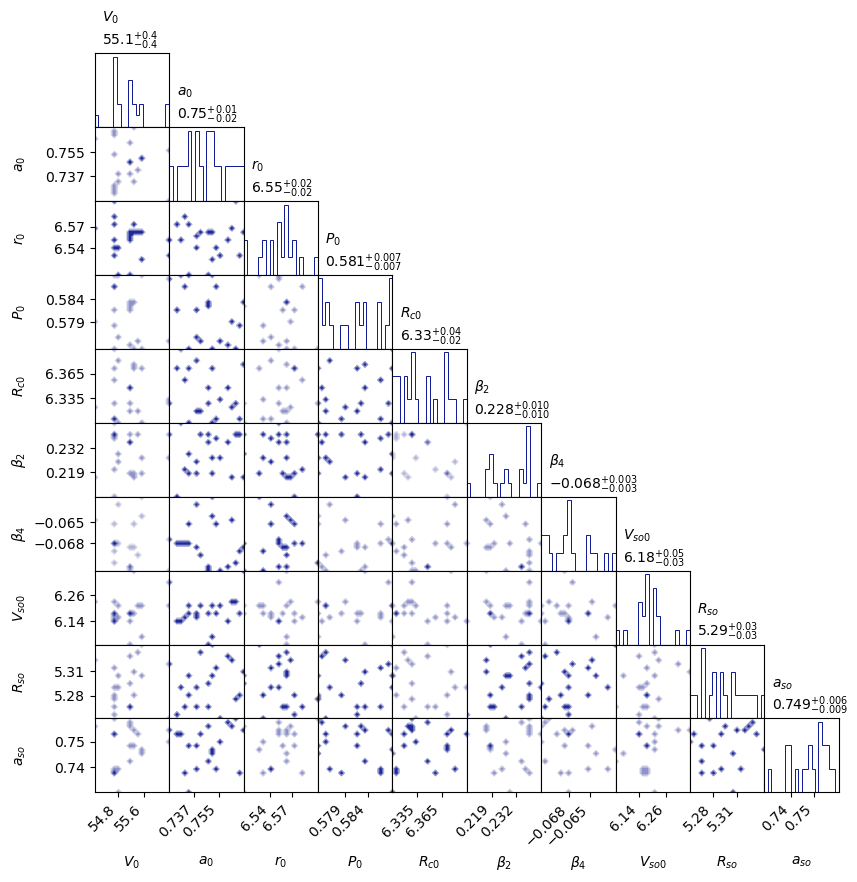

In [108]:
import prettyplease
samples = sampler.get_chain(flat=True)

#a = v0,a0,r0,p0,rc0,beta2,beta4,vso0,rso,aso

labels = ["$V_0$", "$a_0$", "$r_0$", "$P_0$", "$R_{c0}$", "$\\beta_2$", "$\\beta_4$", "$V_{so0}$", "$R_{so}$", "$a_{so}$"]
fig = prettyplease.corner(samples,labels=labels)
plt.show() 